In [1]:
import torch
from torch import nn
from performer_pytorch import Performer
import numpy as np
from copy import deepcopy
from shapely.geometry import Point, Polygon
from matplotlib import pyplot as plt
from torch.optim import Adam
import pickle
from time import time, sleep

In [2]:
def draw_polygon(n, r):
    r = r
    x = np.random.randn(n) 
    y = np.random.randn(n) 

    x = x
    y = y
    
    xmax, xmin = x.max(), x.min()
    ymax, ymin = y.max(), y.min()

    ##computing the (or a) 'center point' of the polygon
    center_point = [np.sum(x)/n, np.sum(y)/n]

    angles = np.arctan2(x-center_point[0],y-center_point[1])

    ##sorting the points:
    sort_tups = sorted([(i,j,k) for i,j,k in zip(x,y,angles)], key = lambda t: t[2])

    ##making sure that there are no duplicates:
    if len(sort_tups) != len(set(sort_tups)):
        return None

    x,y,angles = zip(*sort_tups)
    x = list(x)
    y = list(y)

    ##appending first coordinate values to lists:
    x.append(x[0])
    y.append(y[0])
    return deepcopy([(x[i], y[i]) for i in range(len(x))]), [xmin,xmax], [ymin, ymax]


def get_polygon(n, n_pts, r):
    
    pts = None
    while pts is None:
        pts, xm, ym = draw_polygon(n, r)
    
    poly = Polygon(pts)

    x = np.random.randn(n_pts)
    y = np.random.randn(n_pts)

    x = x / x.max() * (1.2 * xm[1] - 0.8 * xm[0]) + (xm[0] + xm[1])/2.
    y = y / y.max() * (1.2 * ym[1] - 0.8 * ym[0]) + (ym[0] + ym[1])/2.

    r_pts = deepcopy([(x[i], y[i]) for i in range(len(x))])
    ch_pt = [Point(*pt).within(poly) for pt in r_pts]
    return np.array(pts).copy(), np.array(r_pts).copy(), np.array(ch_pt).copy()

def get_input(n, q, r):
    return get_polygon(n, q, r)

In [3]:
class Model(nn.Module):
    
    def __init__(self, d_m, depth, h, ff_m, d_s, o_s):
        super().__init__()
        self.embedd = nn.Linear(d_s, d_m)
        self.enc = Performer(d_m, depth, h, d_m//h, ff_mult=ff_m)
        self.dec = Performer(d_m, depth, h, d_m//h, cross_attend=True, ff_mult=ff_m)
        self.gen = nn.Sequential()
        self.gen.add_module("a1", nn.LeakyReLU(0.1))
        self.gen.add_module("l1", nn.Linear(d_m, d_m))
        self.gen.add_module("a2", nn.LeakyReLU(0.1))
        self.gen.add_module("l2", nn.Linear(d_m, o_s))
        self.gen.add_module('a3', nn.Sigmoid())
    
    def forward(self, x1, x2):
        x = self.enc(self.embedd(x1))
        x = self.dec(self.embedd(x2), context=x)
        x = self.gen(x)
        return x

In [11]:
address = "/home/deniz/Desktop/DLModels/geometry_learner/data"
def create_data(ns):
    output = []
    for k in range(1):
        output.append([])
        r = np.random.randint(1, 100)
        n = np.random.randint(5, 40)
        out_p = np.random.randint(500, 1000)
        enc = []
        dec = []
        out = []
        rs = []
        for i in range(ns):
            e, d, o = get_input(n, out_p, r)
            enc.append(e)
            dec.append(d)
            out.append(o)
            rs.append(r)

        output[k].append([np.array(enc), np.array(dec), np.array(out), np.array(r)])

    with open(f"{address}/data.pickle", 'wb') as fid:
        pickle.dump(output, fid)

def getdata(data, ind):
    d = data[ind]
    # r = d[0][3]
    x_enc = torch.from_numpy(d[0][0]).float()
    x_dec = torch.from_numpy(d[0][1]).float()
    y = torch.from_numpy(d[0][2]).float().unsqueeze(2)
    return x_enc, x_dec, y

print_string = 'epoch {:08d} |mean_loss {:16.08f} |max_loss {:16.08f} | min_loss{:16.08f} |time {:16.08f}s'
device = torch.device('cuda:0')
NUMELE = 10

net = Model(200, 4, 4, 2, 2, 1).to(device)

# net = load('net')
network_opimizer = Adam(net.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()
# prepare dataset
# convertToArray(address)
# prepare_dataset(address, NUMELE, 1)

e_loss = 0.2

for epoch in range(1, 1000000):

    if epoch == 1 or epoch%500 == 0:
        create_data(NUMELE)
        with open(f"{address}/data.pickle", 'rb') as fid:
            data = pickle.load(fid)
        indices = np.array(range(len(data)))

    t = time()
    element_loss = []
    np.random.shuffle(indices) # shuffle the inputs
    for i in indices:   
        x_enc, x_dec, y= getdata(data, i)
        x_enc = x_enc.to(device)
        x_dec = x_dec.to(device)
        y = y.to(device)
        # print(x_dec.max())
        o = net(x_enc, x_dec)
        network_opimizer.zero_grad()

        current_loss = loss_fn(o, y)
        current_loss.backward()
        network_opimizer.step()

        element_loss.append(current_loss.tolist())

    element_loss = np.array(element_loss)

    if element_loss.mean() < e_loss:
        e_loss = element_loss.mean()
        net.save_net('net')
    if epoch % 2000 == 0:
        net.save_net('net_{}'.format(epoch))

    print(print_string.format(epoch, 
                            element_loss.mean(), 
                            element_loss.max(), 
                            element_loss.min(),
                            time()-t))

RuntimeError: CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)`

In [15]:
for i in range(100):
    net(x1, x2)

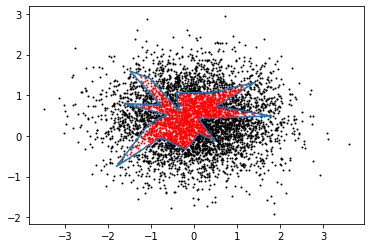

In [19]:
pts, rpts, chpts = get_polygon(20, 5000, 10)
inner = rpts[chpts]
outer = rpts[np.logical_not(chpts)]
plt.plot(pts[:,0], pts[:,1])
plt.scatter(inner[:,0], inner[:,1], s=1, c='r')
plt.scatter(outer[:,0], outer[:,1], s=1, c='black')